## Python Imports

In [1]:
import keras
import numpy as np

import time

import os

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.layers as tfl

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

import pandas as pd

import datetime

import glob

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from tensorflow.keras import utils

import keras
from sklearn.model_selection import train_test_split
# from tensorflow.keras.utils import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from keras.utils import np_utils
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Concatenate
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
# import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing import image_dataset_from_directory
# from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

2025-01-01 16:47:06.486433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735778826.505162   31173 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735778826.511016   31173 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-01 16:47:06.530206: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Declare Base RESNET Model

### Declare Datasets

In [2]:
BATCH_SIZE = 315
IMG_SIZE = (224, 224)
directory = "/home/mason/ADNI_Dataset/ADNI_IMG_32.5%_x_organized"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=20,
                                             label_mode = 'categorical')
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=20,
                                             label_mode = 'categorical')

Found 2182 files belonging to 3 classes.


Using 1746 files for training.
Found 2182 files belonging to 3 classes.
Using 436 files for validation.


W0000 00:00:1735778828.929773   31173 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Declare RESNET 50 Base

In [3]:
# Load the RESNET model without the top layers
base_model = ResNet50(weights='imagenet', include_top = False)

### Declare RESNET 50 Top

In [4]:
# Freeze the base model to retain pretrained weights during training
base_model.trainable = False

# Add a top for 3-way classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling layer
x = Dropout(0.2)(x)              # Dropout for regularization
x = Dense(256, activation='relu')(x)  # Fully connected layer
x = Dropout(0.2)(x)              # Dropout for regularization

predictions = Dense(3, activation='softmax')(x)  # Final output layer with 3 classes

### Combine Base & Top for Complete Model

In [5]:
# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [6]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [7]:
# Early stopping to prevent redundant training.
early_stopping = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30


6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.3202 - loss: 2.6303 - val_accuracy: 0.4679 - val_loss: 1.4695
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.3950 - loss: 1.4299 - val_accuracy: 0.2018 - val_loss: 1.2974
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.3313 - loss: 1.2189 - val_accuracy: 0.4702 - val_loss: 1.0626
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.4322 - loss: 1.1155 - val_accuracy: 0.4495 - val_loss: 1.0223
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.4444 - loss: 1.0370 - val_accuracy: 0.4839 - val_loss: 1.0267
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.4601 - loss: 1.0335 - val_accuracy: 0.5069 - val_loss: 1.0135
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.4727 - loss: 1.0212 - val_accuracy: 0.5229 - val_loss: 1.0076
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.4733 - loss: 1.0137 - val_accuracy: 0.5023 - val_loss: 1.0063
Epoch 9/30
6/6 ━━━━

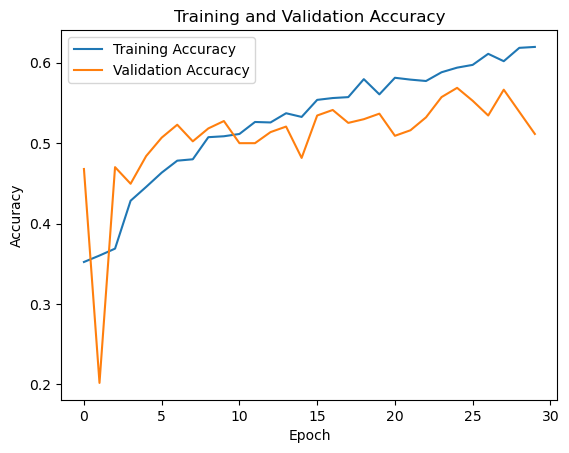

In [8]:
# Get training and validation accuracy and loss from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

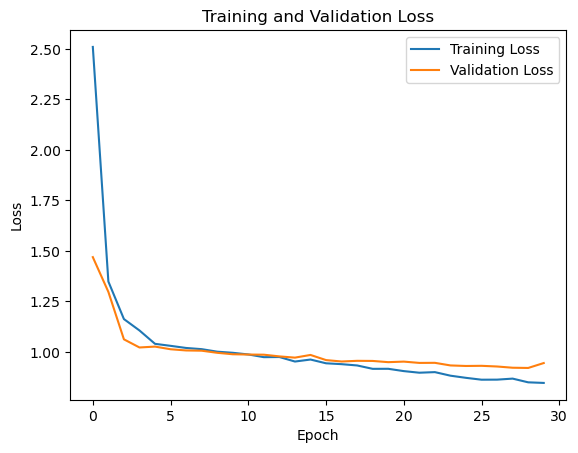

In [9]:
# Plot training and validation loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [10]:
# Get the final accuracy and loss for the last epoch
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Print the final accuracy and loss
print("Final Training Accuracy:", final_train_acc)
print("Final Validation Accuracy:", final_val_acc)
print("Final Training Loss:", final_train_loss)
print("Final Validation Loss:", final_val_loss)

Final Training Accuracy: 0.619702160358429
Final Validation Accuracy: 0.5114678740501404
Final Training Loss: 0.8468893766403198
Final Validation Loss: 0.9452478885650635
